# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'timegan_lstm'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h        snow_1h  \
count   341988.000000  341988.000000  341988.000000  341988.000000   
mean      3223.797936     282.704303       0.086439       0.000249   
std       1943.974204      12.922822       0.321004       0.000466   
min         41.627638     250.083873       0.000008       0.000000   
25%       1152.987320     270.511312       0.000130       0.000002   
50%       3608.409516     285.328962       0.000575       0.000006   
75%       5010.047921     293.711888       0.037928       0.000324   
max       7076.619110     305.881726      12.279954       0.004205   

          clouds_all  
count  341988.000000  
mean       39.871618  
std        39.339560  
min         0.016394  
25%         4.172619  
50%        15.465574  
75%        87.893841  
max        97.951007  


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 1,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  1
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.08062343053519726
Training Loss: 0.06642903212457896
Training Loss: 0.06181913329288363
Validation Loss: 0.05447646247202091
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05508267756551504
Training Loss: 0.051767145013436676
Training Loss: 0.04847046514973044
Validation Loss: 0.04159125030626742
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04185208454728127
Training Loss: 0.03883950431831181
Training Loss: 0.03560708126053214
Validation Loss: 0.029917515186446437
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.030026706736534833
Training Loss: 0.02802911546546966
Training Loss: 0.02546667610760778
Validation Loss: 0.020779811944603252
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.021296823509037496
Training Loss: 0.020030606114305557
Trainin

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_evaluation/predictive/predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
100%|██████████| 1/1 [06:32<00:00, 392.91s/it]


Validation Loss: 0.0029088960479149656
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.0863050764799118
Training Loss: 0.07525944821536541
Training Loss: 0.07094679415225982
Validation Loss: 0.0688161797654093
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06696818465366959
Training Loss: 0.06470962762832641
Training Loss: 0.061684971917420624
Validation Loss: 0.05897247791290283
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05692142991349101
Training Loss: 0.05374742953106761
Training Loss: 0.04972656198777258
Validation Loss: 0.04611172520796235
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.043981257965788244
Training Loss: 0.040666234102100136
Training Loss: 0.03664473716169596
Validation Loss: 0.03330815492428086
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03164427007548511
Training Loss: 0.029116726713255048
Training Lo

100%|██████████| 1/1 [06:52<00:00, 412.83s/it]


Validation Loss: 0.003596629229965463
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.5285365414619446
Training Loss: 0.42813996762037276
Training Loss: 0.34517516285181044
Validation Loss: 0.2623803502354542
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.22669065490365028
Training Loss: 0.1559789028391242
Training Loss: 0.11662650529295206
Validation Loss: 0.09807619431664824
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.09389837661758066
Training Loss: 0.08303824350237847
Training Loss: 0.0785623618401587
Validation Loss: 0.07393524198475497
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07178477194160222
Training Loss: 0.06464132441207766
Training Loss: 0.061429268680512905
Validation Loss: 0.057999755958272094
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.05584836948662996
Training Loss: 0.049448764976114036
Training Loss:

100%|██████████| 1/1 [06:42<00:00, 402.89s/it]


Validation Loss: 0.0014603878798219506
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.6655557334423066
Training Loss: 0.5249321313202381
Training Loss: 0.39340171352028847
Training Loss: 0.25843413345515726
Training Loss: 0.1528220918774605
Training Loss: 0.09573336279019713
Training Loss: 0.07359154963865876
Validation Loss: 0.06420086335376854
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0621532834880054
Training Loss: 0.058435858357697726
Training Loss: 0.05677721002139151
Training Loss: 0.05610850860364735
Training Loss: 0.05356377457268536
Training Loss: 0.04958531118929386
Training Loss: 0.0475667604804039
Validation Loss: 0.046430624867981295
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.047268065521493555
Training Loss: 0.0445742988679558
Training Loss: 0.04207473372109234
Training Loss: 0.038591786837205294
Training Loss: 0.032768548484891656
Training Loss: 0.0279962286259979
Training Loss: 0.02475082514807582
Validation Los

100%|██████████| 1/1 [12:55<00:00, 775.06s/it]


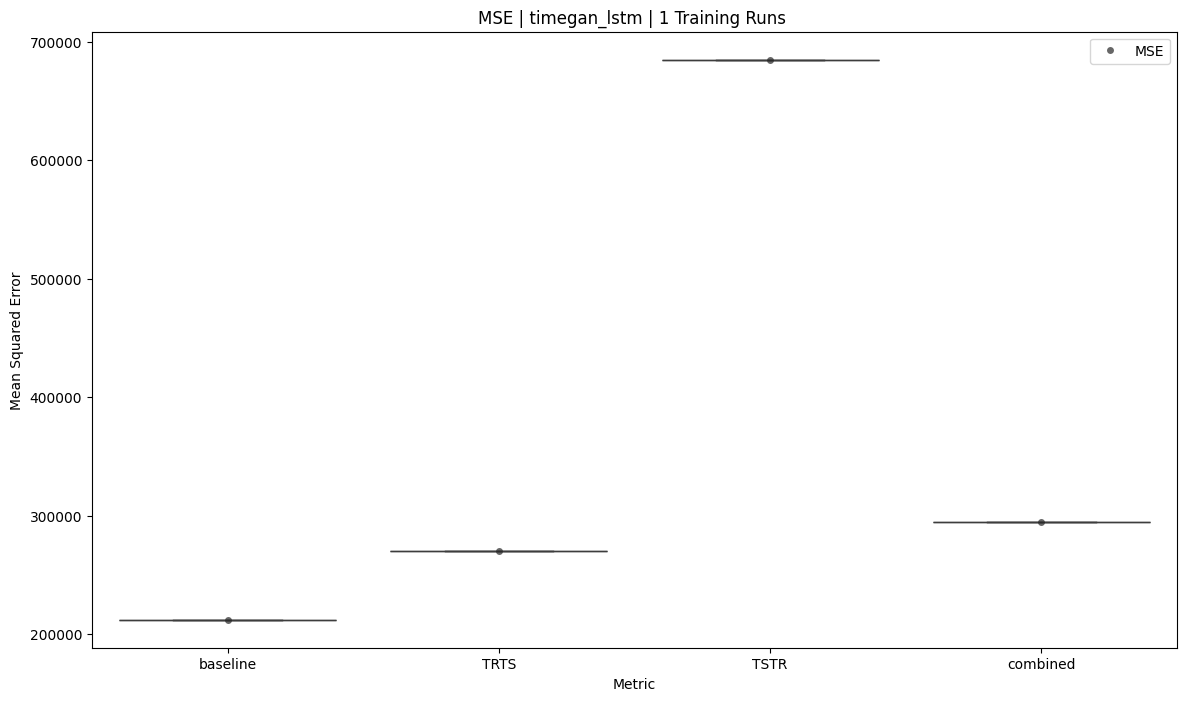

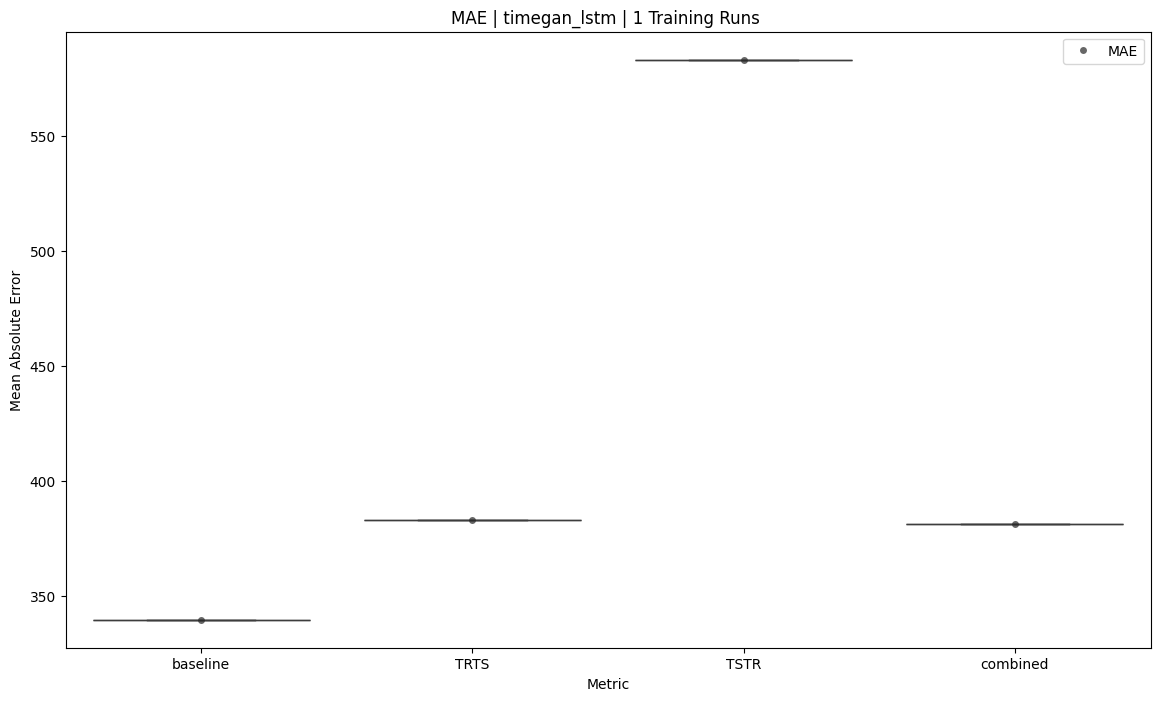

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [9]:
0.2*1e06

200000.0